# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some of the computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates.

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation.
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [12]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1 - tanh(self.v)**2)])

    def sigmoid(self):
        sig = 1 / (1 + exp(-self.v))
        return Var(sig, lambda: [(self, sig * (1 - sig))])

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [ ]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [ ]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

Solution for a:

The output of the code provides the value of the variable and the gradient for the function with respect to the variable itself. The output for instance is printed as $ Var(v=3.0000, grad=5.0000)$ where $v$ represents the value of the variable itself and the $grad$ represents the gradient which is found by the backpropagaition of the function with respect to the variables.


Lets consider the second example, we differentiate the function f with respect to the a, b, c, d, and e. The function f is given by,

$$
f=c+e
$$

To further simplify we can write c and e in terms of the a, b and a, d respectively.

$$
f=(a×b)+(a×d)
$$

Now, when the function f passes through the backward() which does the back propogation. we calculate the gradient for each variable dependent.

With respect a,
$$
\frac{\partial f}{\partial a} = \frac{\partial (a \times b)}{\partial a} + \frac{\partial (a \times d)}{\partial a}
$$

$$
\frac{\partial f}{\partial a} = b + d = 5 + 9 = 14
$$

With respect b,

$$
\frac{\partial f}{\partial b} = \frac{\partial (a \times b)}{\partial b} = a = 3
$$

with respect to c,
$$
\frac{\partial f}{\partial c} =\frac{\partial (c + e)}{\partial c}  = 1
$$

with respect to d,
$$
\frac{\partial f}{\partial d} = \frac{\partial (a \times d)}{\partial d} = a = 3
$$

with respect to e,

$$
\frac{\partial f}{\partial e} =\frac{\partial (c + e)}{\partial e}  = 1
$$

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder consider the first expression. Make a schematic of the data structure which is generated when we define the expression for f.

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables.

4. Write down the sequence of calls to backprop.

In [ ]:
#import logging
import graphviz

#logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

#graphviz.__version__, graphviz.version()

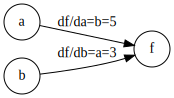

In [ ]:
e1 = graphviz.Digraph('first expression', filename='fsm.gv')

e1.attr(rankdir='LR', size='8,5')
e1.attr('node', shape='circle')
e1.edge('a', 'f', label='df/da=b=5')
e1.edge('b', 'f', label='df/db=a=3')

e1

Solution for b:

The function of the f is provided as $f=a*b$

The backpropagation is the influence of the variables on the function f. So, do that we partial differentiate the function f with the variables a and b respectively to get the influence of these variables on the function.

To do that we now partial differentiate the function f with the a,
$$
\frac{\partial f}{\partial a} =\frac{\partial (a * b)}{\partial a}  = 5
$$
To do that we now partial differentiate the function f with the b,
$$
\frac{\partial f}{\partial b} =\frac{\partial (a * b)}{\partial b}  = 3
$$
Therefore, we can see that the answer computed and the derived are equal. so the function indeed calculates the back propagation with respect to the variables.  

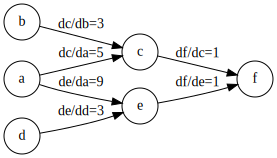

In [ ]:
e2 = graphviz.Digraph('second expression', filename='fsm.gv')

e2.attr(rankdir='LR', size='8,5')

e2.attr('node', shape='circle')
e2.edge('a', 'c', label='dc/da=5')
e2.edge('b', 'c', label='dc/db=3')
e2.edge('a', 'e', label='de/da=9')
e2.edge('d', 'e', label='de/dd=3')
e2.edge('c', 'f', label='df/dc=1')
e2.edge('e', 'f', label='df/de=1')

e2

The function of the f is provided as $f=c+e$

The backpropagation is the influence of the variables on the function f. So, do that we partial differentiate the function f with the variables respectively to get the influence of these variables on the function.

To do that we now partial differentiate the function c with the a,
$$
\frac{\partial c}{\partial a} =\frac{\partial (a * b)}{\partial a}  = 5
$$
we now partial differentiate the function c with the b,
$$
\frac{\partial c}{\partial b} =\frac{\partial (a * b)}{\partial b}  = 3
$$
we now partial differentiate the function e with the a,
$$
\frac{\partial e}{\partial a} =\frac{\partial (a * d)}{\partial a}  = 9
$$
we now partial differentiate the function e with the d,
$$
\frac{\partial e}{\partial d} =\frac{\partial (a * d)}{\partial d}  = 3
$$
we now partial differentiate the function f with the c,
$$
\frac{\partial f}{\partial c} =\frac{\partial (c + e)}{\partial c}  = 1
$$
we now partial differentiate the function f with the e,
$$
\frac{\partial f}{\partial e} =\frac{\partial (c + e)}{\partial e}  = 1
$$

Therefore, we can see that the answer computed and the derived are equal. so the function indeed calculates the back propagation with respect to the variables.  

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [ ]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


solution for c:

When the code for calculating and printing f.backward() for the variables runs twice, the gradients are doubled. This is due the intialisation of the code where it's given as $ self.grad += bp $. So, when each time the gradient is calculated it keeps getting accumulated to the gradients. Now we can understand that for multiple calls to backward(), this line results in gradients being added up.

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [ ]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


Solution for d:

 When f.backprop(-1.0) is called the backprop function computes the gradients by propagating a value of -1.0 back through the computational graph. This effectively adjusts the gradients of each variable that contributed to the calculation of f.Since gradients accumulate, the -1.0 backpropagated through the network will subtract from the gradients of all the variables involved in the computation of f. The result is that each variable’s gradient is reduced by half (i.e., approximately halving each gradient). So, therefore this could be used to mitigate the issue of accumulation of gradients.



## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above.


Solution for e:

In [ ]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
a=4.00
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between

    Input:
    da:          The finite difference                           (float)

    Output:
    finite_difference: numerical approximation to the derivative (float)
    """
    fa_da = (a+da)*5
    fa = a*5

    finite_difference = (fa_da - fa) / da

    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000018177270249


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [15]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T

    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)

    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)

    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma

    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [16]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

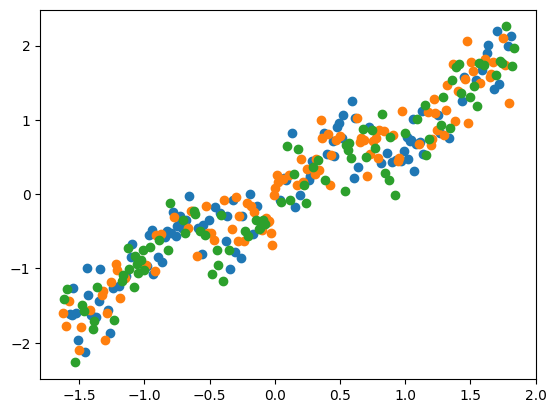

In [17]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()


In [18]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y

x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it.
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [19]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [20]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [21]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def print_parameters(self, layer_index: int):
        print(f"Layer {layer_index}:")
        print("  Weights:")
        for i, row in enumerate(self.weights):
            for j, weight in enumerate(row):
                print(f"    Weight[{i}][{j}] = {weight.v:.4f}, Grad = {weight.grad:.4f}")
        print("  Biases:")
        for k, bias in enumerate(self.bias):
            print(f"    Bias[{k}] = {bias.v:.4f}, Grad = {bias.grad:.4f}")

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            # Start with the bias of the current node
            node = self.bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j] * single_input[i]
            node = self.act_fn(node)
            out.append(node)

        return out



## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu).

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

Solution for f:

The activation function for the sigmoid and hyperbolic tangent are added to the var class in the above where the class var is defined. Please, refer to it.

---
The function for these activation can be written as:




    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1 - tanh(self.v)**2)])

    def sigmoid(self):
        sig = 1 / (1 + exp(-self.v))
        return Var(sig, lambda: [(self, sig * (1 - sig))])




## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [22]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0003, grad=0.0000)], [Var(v=0.0005, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0129, grad=0.0000)], [Var(v=0.0004, grad=0.0000)], [Var(v=0.0004, grad=0.0000)], [Var(v=0.0002, grad=0.0000)], [Var(v=0.0031, grad=0.0000)], [Var(v=0.0133, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=0.0004, grad=0.0000)], [Var(v=0.0082, grad=0.0000)], [Var(v=0.0003, grad=0.0000)], [Var(v=0.0093, grad=0.0000)], [Var(v=0.0002, grad=0.0000)], [Var(v=0.0003, grad=0.0000)], [Var(v=0.0006, grad=0.0000)], [Var(v=0.0003, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=0.0061, grad=0.0000)], [Var(v=0.0027, grad=0.0000)], [Var(v=0.0005, grad=0.0000)], [Var(v=0.0005, grad=0.0000)], [Var(v=0.0036, grad=0.0000)], [Var(v=0.0096, grad=0.0000)], [Var(v=0.0006, grad=0.0000)], [Var(v=0.0007, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=0.0004, grad=0.0000)], [Var(v=0.0121, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=0.0105, grad=0.0000)], [Var(v=0.

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var.

Solution for H:

The print paramter function is defined in the class DenseLayer above. Please refer to it. We then create a function to print the network paramters and call it to print the parameters accordingly as shown below.

In [23]:
def print_network_parameters(network):
    for layer_index, layer in enumerate(network):
        layer.print_parameters(layer_index)

In [24]:
print_network_parameters(NN)

Layer 0:
  Weights:
    Weight[0][0] = 0.0079, Grad = 0.0000
    Weight[0][1] = -0.0743, Grad = 0.0000
    Weight[0][2] = 0.0447, Grad = 0.0000
    Weight[0][3] = -0.0044, Grad = 0.0000
    Weight[0][4] = -0.0137, Grad = 0.0000
  Biases:
    Bias[0] = 0.0000, Grad = 0.0000
    Bias[1] = 0.0000, Grad = 0.0000
    Bias[2] = 0.0000, Grad = 0.0000
    Bias[3] = 0.0000, Grad = 0.0000
    Bias[4] = 0.0000, Grad = 0.0000
Layer 1:
  Weights:
    Weight[0][0] = 0.0209, Grad = 0.0000
    Weight[1][0] = 0.1394, Grad = 0.0000
    Weight[2][0] = 0.0045, Grad = 0.0000
    Weight[3][0] = -0.1296, Grad = 0.0000
    Weight[4][0] = -0.0973, Grad = 0.0000
  Biases:
    Bias[0] = 0.0000, Grad = 0.0000


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

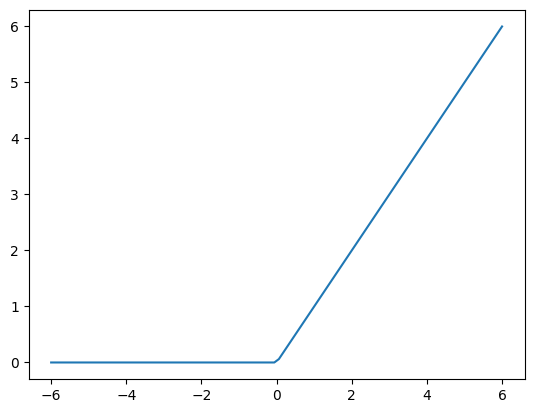

In [25]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ]
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

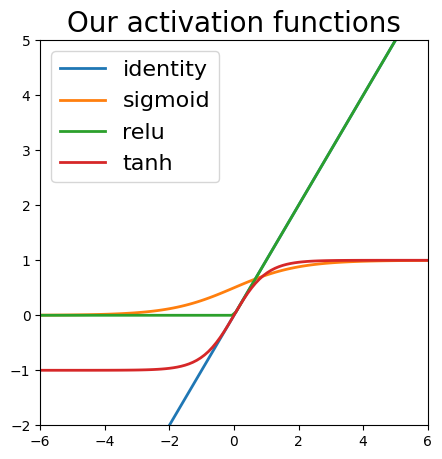

In [26]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]

plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf).

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer.

The Glorot initialization has the form:

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).)

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization

Using the Initializer class, implement functions that implement Glorot and He

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

Solution for i:

---



We replace the expressions with the definitions given above to the code.


In [27]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  std = (2 * 1 / (n_in + n_out)) ** 0.5
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = (2 / n_in) ** 0.5
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

Numerical testing for tese initialisation:

The issue with not having these initialisation is that the activation value goes to an zero at the later layers but in the earlier layers they are more uniform and spread-out. And also, during back propagation, the gradients for the final layers are properly distributed but when back propogated to the initial layers you would notice that there is vanishing gradient. So, when numerically testing these initializing, we can test them out whether based on the presence of vanishing gradients.



## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions.

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands.

Solution for j:

In [28]:
# Convert Var object to numpy array for easier assertion checks
def Var_to_nparray(var_list):
    if isinstance(var_list[0], list):
        return np.array([[var.v for var in row] for row in var_list])
    else:
        return np.array([var.v for var in var_list])


In [29]:
def test_forward_pass():
    x = np.array([[1.0, 2.0]])
    x_var = nparray_to_Var(x)
    n_in, n_out = 2, 1
    layer = DenseLayer(n_in, n_out, act_fn=lambda x: x.identity(), initializer=ConstantInitializer(weight=1.0, bias=1.0))
    # Performing forward pass
    output = layer.forward(x_var[0])
    expected_output = (x @ np.ones((n_in, n_out))) + 1
    output_np = Var_to_nparray(output)
    # Assert that output matches the expected output
    assert np.allclose(output_np, expected_output), f"Test failed: Expected {expected_output}, got {output_np}"
    print("Test passed! Forward pass works correctly.")
test_forward_pass()


Test passed! Forward pass works correctly.


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [30]:
def squared_loss(t, y):
  assert len(t) == len(y), "Target and prediction must have the same number of elements."
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    # sum over outputs
    for i in range(len(t)):
      Loss += (t[i]-y[i]) ** 2
    return Loss
  Loss = Var(0.0)
  # sum over training data
  for n in range(len(t)):
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector.

Call the function to convince yourself it works.

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

Solution for k:

In [31]:
def cross_entropy_loss(t, h):
    # Ensure t and h are Var objects
    assert len(t) == len(h), "Target and logits must have the same number of elements."
    # Compute softmax probabilities
    exp_h = [hi.exp() for hi in h]
    sum_exp_h = Var(sum([ehi.v for ehi in exp_h]))
    softmax = [ehi / sum_exp_h for ehi in exp_h]
    # Compute LogSumExp term
    log_sum_exp = sum_exp_h.log()
    # Compute loss
    loss = Var(0.0)
    for ti, pi in zip(t, softmax):
        loss -= ti * pi.log()
    # Add LogSumExp term
    loss += log_sum_exp

    return loss


# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [32]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [33]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Layer 0 
 Weights: [[Var(v=0.0695, grad=-0.5352), Var(v=0.1263, grad=-2.6529), Var(v=-0.1990, grad=11.4588), Var(v=0.0038, grad=-20.4790), Var(v=-0.0815, grad=-0.9702)]] Biases: [Var(v=0.0000, grad=-0.4598), Var(v=0.0000, grad=-2.2791), Var(v=0.0000, grad=-10.4109), Var(v=0.0000, grad=-17.5930), Var(v=0.0000, grad=0.8815)]
Layer 1 
 Weights: [[Var(v=0.0053, grad=-7.0291)], [Var(v=0.0262, grad=-12.7652)], [Var(v=-0.1223, grad=18.6370)], [Var(v=0.2026, grad=-0.3844)], [Var(v=0.0104, grad=7.6333)]] Biases: [Var(v=0.0000, grad=-1.7644)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [34]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [35]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Network before update:
Layer 0 
 Weights: [[Var(v=0.0672, grad=-2.8017), Var(v=0.1214, grad=-1.0613), Var(v=0.0112, grad=1.3481), Var(v=-0.1239, grad=-1.0331), Var(v=-0.0931, grad=3.4650), Var(v=0.0673, grad=0.9751), Var(v=0.0552, grad=4.8361), Var(v=0.0247, grad=0.7295), Var(v=-0.1492, grad=-2.3219), Var(v=0.0990, grad=1.5698), Var(v=-0.0202, grad=-0.5982), Var(v=-0.0230, grad=-3.6922), Var(v=-0.2906, grad=7.8901), Var(v=0.0556, grad=2.5594), Var(v=0.0352, grad=-4.7519)]] Biases: [Var(v=0.0000, grad=-2.4066), Var(v=0.0000, grad=-0.9116), Var(v=0.0000, grad=1.1580), Var(v=0.0000, grad=0.9387), Var(v=0.0000, grad=-3.1482), Var(v=0.0000, grad=0.8376), Var(v=0.0000, grad=4.1540), Var(v=0.0000, grad=0.6266), Var(v=0.0000, grad=2.1097), Var(v=0.0000, grad=1.3484), Var(v=0.0000, grad=0.5435), Var(v=0.0000, grad=3.3547), Var(v=0.0000, grad=-7.1688), Var(v=0.0000, grad=2.1984), Var(v=0.0000, grad=-4.0817)]
Layer 1 
 Weights: [[Var(v=0.0354, grad=0.8551), Var(v=-0.0083, grad=0.0000), Var(v=-0.0

[None, None, None]

In [ ]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D:
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients
## of the activation functions.

In [ ]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3

In [ ]:
train_loss = []
val_loss = []

for e in range(EPOCHS):

    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()

    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))

    # Training loss
    train_loss.append(Loss.v)

    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)

    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100),
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))



   0 ( 0.00%) Train loss: 105.772 	 Validation loss: 106.815
  10 ( 5.00%) Train loss: 45.800 	 Validation loss: 32.890
  20 (10.00%) Train loss: 14.309 	 Validation loss: 10.718
  30 (15.00%) Train loss: 13.868 	 Validation loss: 10.407
  40 (20.00%) Train loss: 13.455 	 Validation loss: 10.115
  50 (25.00%) Train loss: 13.002 	 Validation loss: 9.788
  60 (30.00%) Train loss: 12.642 	 Validation loss: 9.500
  70 (35.00%) Train loss: 12.367 	 Validation loss: 9.343
  80 (40.00%) Train loss: 12.184 	 Validation loss: 9.176
  90 (45.00%) Train loss: 12.077 	 Validation loss: 9.080
 100 (50.00%) Train loss: 12.012 	 Validation loss: 9.020
 110 (55.00%) Train loss: 11.962 	 Validation loss: 9.002
 120 (60.00%) Train loss: 11.929 	 Validation loss: 9.002
 130 (65.00%) Train loss: 11.910 	 Validation loss: 9.008
 140 (70.00%) Train loss: 11.899 	 Validation loss: 9.017
 150 (75.00%) Train loss: 11.893 	 Validation loss: 9.022
 160 (80.00%) Train loss: 11.889 	 Validation loss: 9.025
 170 (8

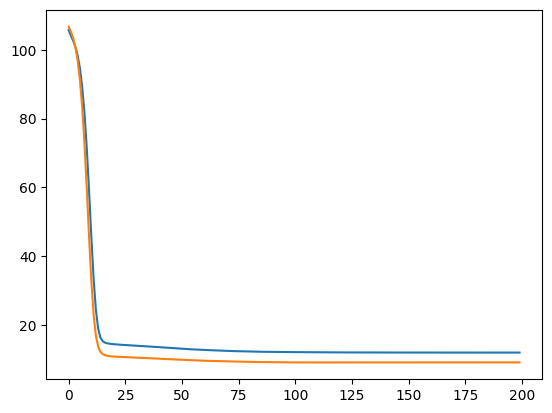

In [ ]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [ ]:
output_test = forward(x_test, NN)

Test loss:  9.828


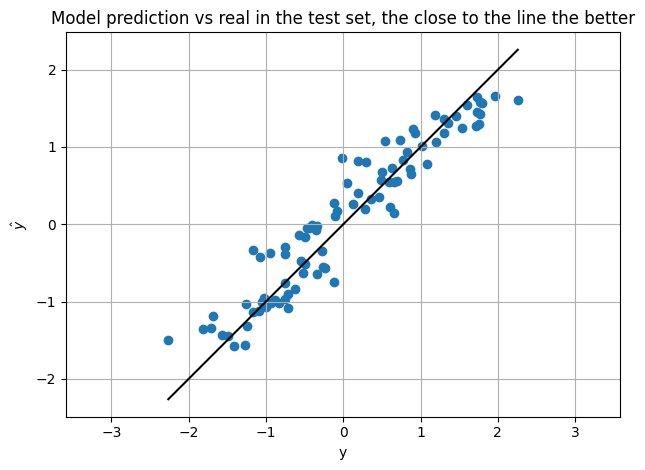

In [ ]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

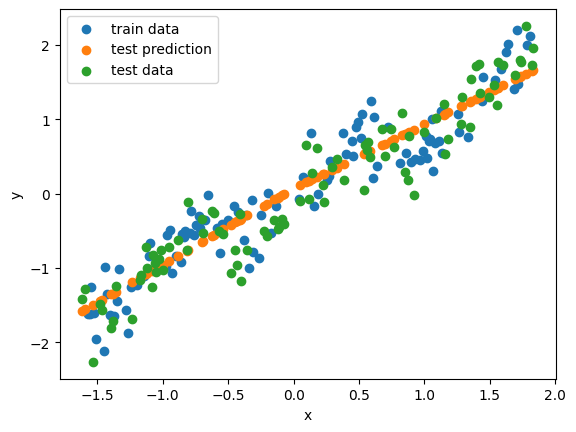

In [ ]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss.

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

Solution for l:

The training  loss is calculated on the training dataset after each epoch. It indicates how well the model is learning the patterns in the training data. The training loss typically decreases over time as the model adjusts its parameters to fit the training data better.If the training loss is significantly low compared to the validation loss, it may be a sign of overfitting—where the model is memorizing the training data rather than generalizing well to unseen data.

The Validation loss is calculated on the validation dataset, which is not used for training but is used to monitor the model's generalization to unseen data during training. Ideally, the validation loss decreases initially as the model improves but may stabilize or even start to increase if the model begins to overfit. If the validation loss remains high or increases while the training loss decreases, this indicates that the model is overfitting. Conversely, if both losses remain high, it may indicate underfitting, meaning the model is too simple or not properly learning from the data.


## underfitting ##

Epoch 0, Train loss: 105.4583, Validation loss: 104.6259
Epoch 20, Train loss: 29877.6997, Validation loss: 36813.4971
Epoch 40, Train loss: 1347595.2233, Validation loss: 1635150.8304
Epoch 60, Train loss: 60986509.3935, Validation loss: 73824468.3711
Epoch 80, Train loss: 2760199367.6287, Validation loss: 3340048498.5431
Epoch 100, Train loss: 124924563951.4044, Validation loss: 151160116858.3139
Epoch 120, Train loss: 5653992761972.3789, Validation loss: 6841340623441.8037
Epoch 140, Train loss: 255895503390076.5625, Validation loss: 309633622215842.6250
Epoch 160, Train loss: 11581639986673852.0000, Validation loss: 14013784808473914.0000
Epoch 180, Train loss: 524176404055475072.0000, Validation loss: 634253451763611392.0000


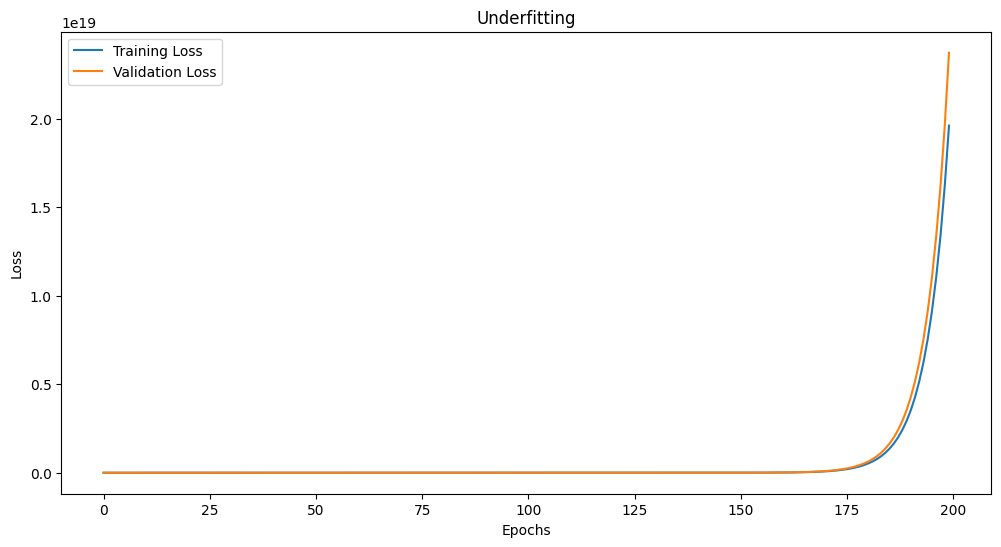

In [ ]:
NN_underfit = [
    DenseLayer(1, 2, lambda x: x.relu()),
    DenseLayer(2, 1, lambda x: x.identity())
]
EPOCHS = 200
LEARN_R = 1e-2
train_loss = []
val_loss = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train, forward(x_train, NN_underfit))
    Loss.backward()
    update_parameters(parameters(NN_underfit), LEARN_R)
    zero_gradients(parameters(NN_underfit))
    train_loss.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_underfit))
    val_loss.append(Loss_validation.v)
    if e % 20 == 0:
        print(f"Epoch {e}, Train loss: {train_loss[-1]:.4f}, Validation loss: {val_loss[-1]:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Underfitting')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The training loss and validation loss both start high and continue to increase. The model is unable to learn the data properly, leading to large errors in both the training and validation sets. This is due to an overly simple architecture.

## Right fit ##

Epoch 0, Train loss: 107.6024, Validation loss: 107.1304
Epoch 20, Train loss: 13.6637, Validation loss: 10.4100
Epoch 40, Train loss: 18.5654, Validation loss: 15.0202
Epoch 60, Train loss: 13.4459, Validation loss: 10.4344
Epoch 80, Train loss: 13.1980, Validation loss: 10.2922
Epoch 100, Train loss: 12.8622, Validation loss: 10.1142
Epoch 120, Train loss: 12.6424, Validation loss: 9.9392
Epoch 140, Train loss: 12.5138, Validation loss: 9.8521
Epoch 160, Train loss: 12.4565, Validation loss: 9.7931
Epoch 180, Train loss: 12.3345, Validation loss: 9.6756


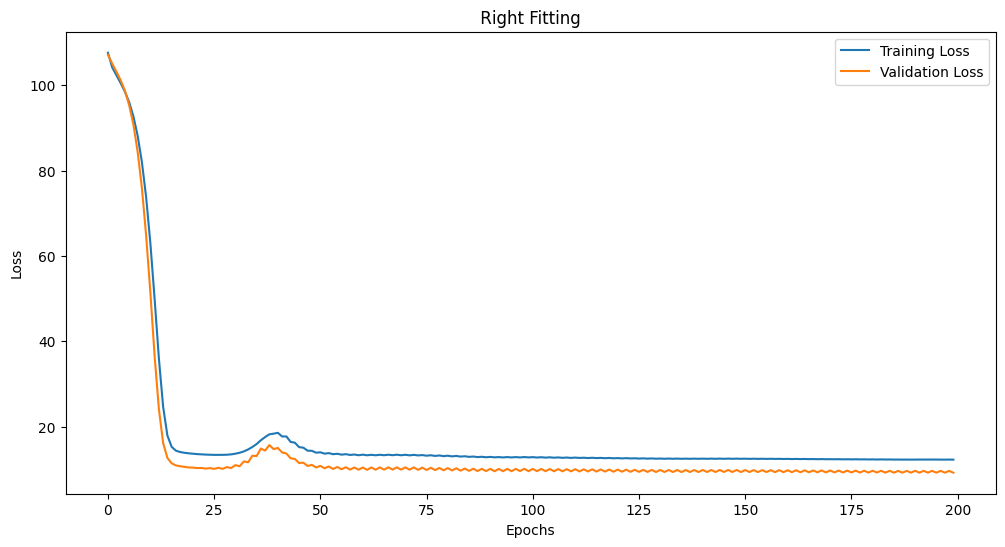

In [36]:
NN_optimal = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]
EPOCHS = 200
LEARN_R = 2e-3
train_loss = []
val_loss = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train, forward(x_train, NN_optimal))
    Loss.backward()
    update_parameters(parameters(NN_optimal), LEARN_R)
    zero_gradients(parameters(NN_optimal))
    train_loss.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_optimal))
    val_loss.append(Loss_validation.v)
    if e % 20 == 0:
        print(f"Epoch {e}, Train loss: {train_loss[-1]:.4f}, Validation loss: {val_loss[-1]:.4f}")
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title(' Right Fitting ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The training loss and validation loss are both low and close to each other, indicating that the model fits well without overfitting or underfitting.The model architecture has enough complexity to learn the data's patterns without overfitting. It strikes a good balance between model capacity and generalization. And also, the data has less validation loss compared to the training loss.

## overfitting ##

Epoch 0, Train loss: 42.1118, Validation loss: 106.4768
Epoch 10, Train loss: 39.4691, Validation loss: 99.9430
Epoch 20, Train loss: 36.3778, Validation loss: 92.4525
Epoch 30, Train loss: 31.0821, Validation loss: 79.6762
Epoch 40, Train loss: 21.8904, Validation loss: 57.2188
Epoch 50, Train loss: 11.2317, Validation loss: 30.3797
Epoch 60, Train loss: 6.6032, Validation loss: 17.0878
Epoch 70, Train loss: 5.5323, Validation loss: 13.6617
Epoch 80, Train loss: 5.1988, Validation loss: 12.6300
Epoch 90, Train loss: 5.0621, Validation loss: 12.2429
Epoch 100, Train loss: 4.9688, Validation loss: 12.0451
Epoch 110, Train loss: 4.8845, Validation loss: 11.9143
Epoch 120, Train loss: 4.8077, Validation loss: 11.8200
Epoch 130, Train loss: 4.7245, Validation loss: 11.7245
Epoch 140, Train loss: 4.6514, Validation loss: 11.6313
Epoch 150, Train loss: 4.5945, Validation loss: 11.5363
Epoch 160, Train loss: 4.5421, Validation loss: 11.4457
Epoch 170, Train loss: 4.4901, Validation loss: 11.3

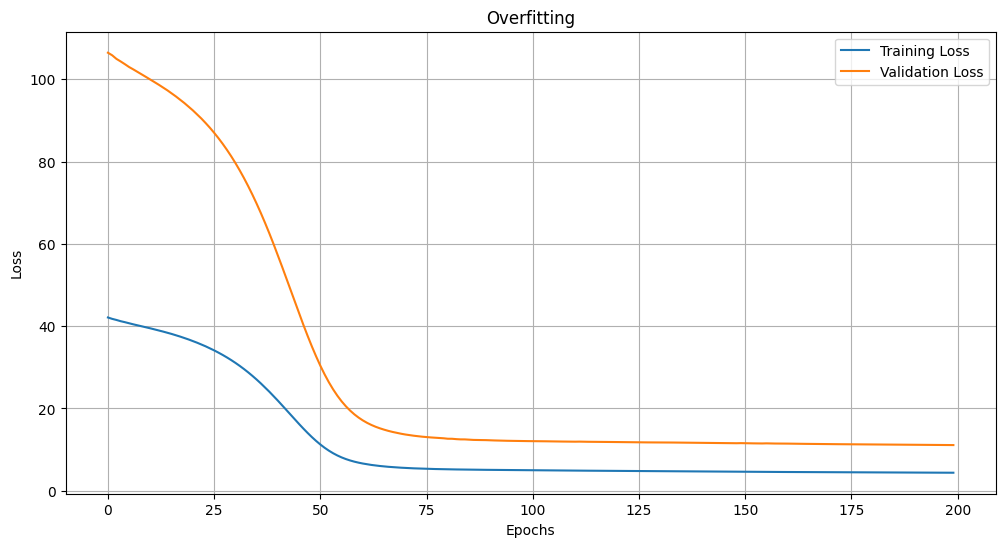

In [ ]:
NN_overfit = [
    DenseLayer(1, 30, lambda x: x.relu()),
    DenseLayer(30, 60, lambda x: x.relu()),
    DenseLayer(60, 30, lambda x: x.relu()),
    DenseLayer(30, 1, lambda x: x.identity())
]
x_train_small, y_train_small = x_train[:50], y_train[:50]

EPOCHS = 200
LEARN_R = 1e-3
train_loss = []
val_loss = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train_small, forward(x_train_small, NN_overfit))
    Loss.backward()
    update_parameters(parameters(NN_overfit), LEARN_R)
    zero_gradients(parameters(NN_overfit))
    train_loss.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_overfit))
    val_loss.append(Loss_validation.v)
    if e % 10 == 0:
        print(f"Epoch {e}, Train loss: {train_loss[-1]:.4f}, Validation loss: {val_loss[-1]:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Overfitting')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training loss is very low, meaning the model fits the training data well. However, the validation loss is significantly higher, indicating that the model does not generalize well to new data.This is due to an overly complex architecture, which can memorize the training data and pick up on noise rather than the true underlying patterns.

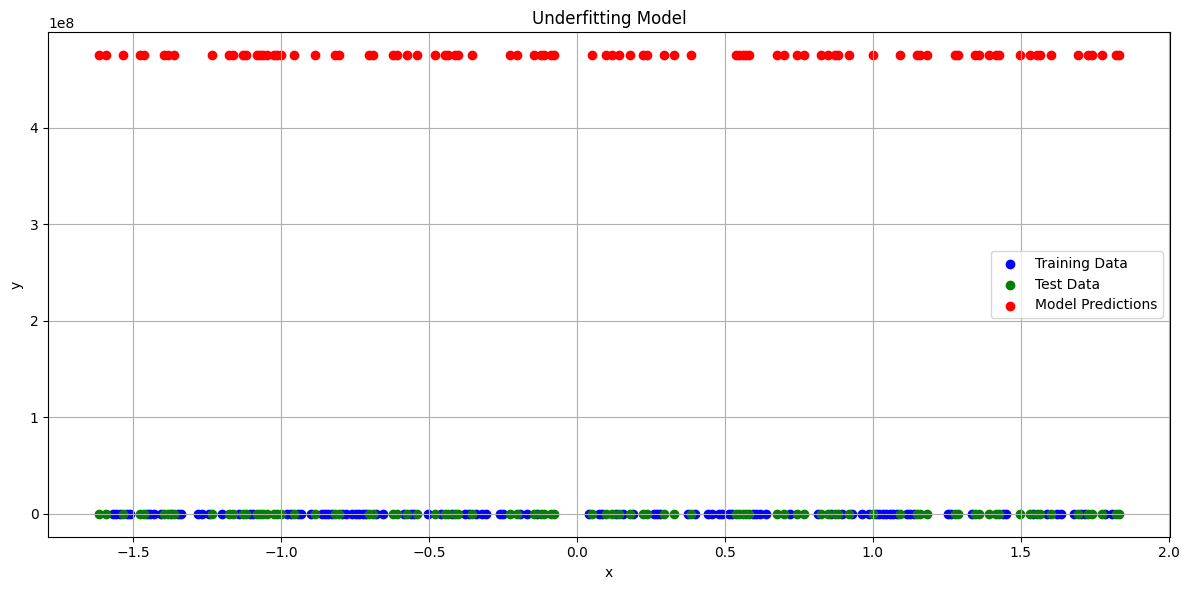

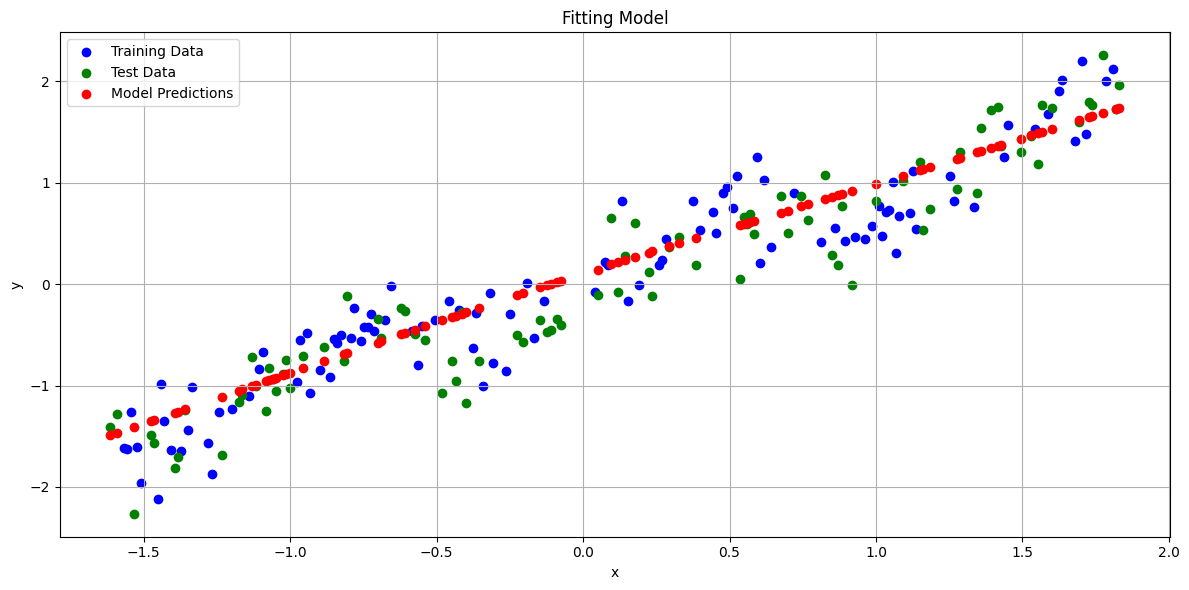

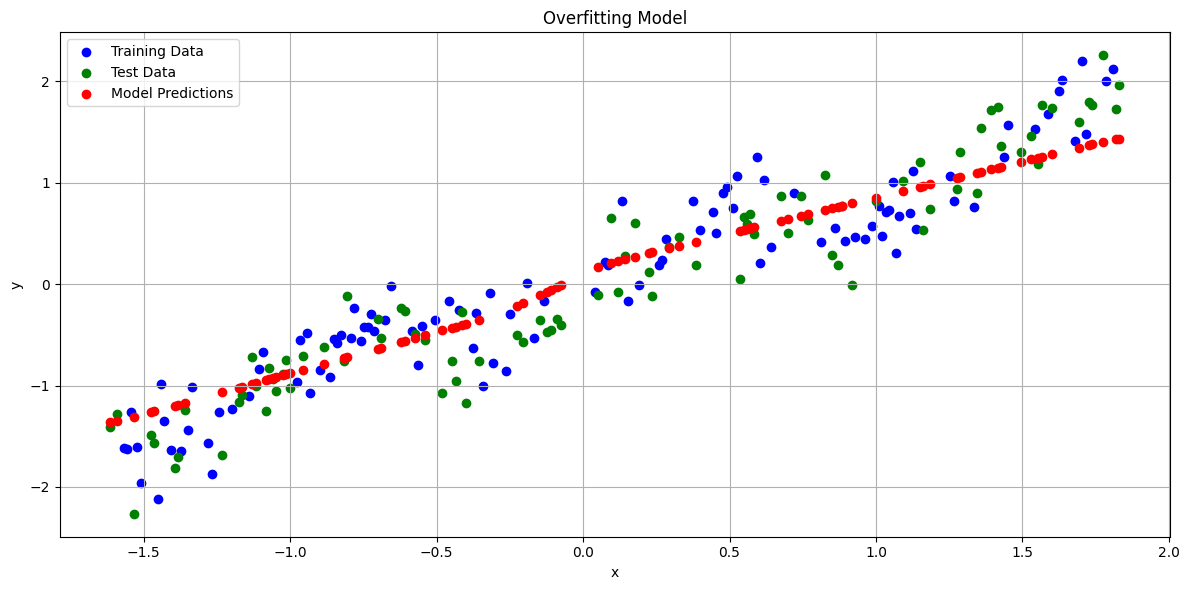

In [ ]:
import matplotlib.pyplot as plt
def plot_predictions(x_train, y_train, x_test, y_test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.scatter(Var_to_nparray(x_train), Var_to_nparray(y_train), color='blue', label='Training Data')
    plt.scatter(Var_to_nparray(x_test), Var_to_nparray(y_test), color='green', label='Test Data')
    plt.scatter(Var_to_nparray(x_test), Var_to_nparray(predictions), color='red', label='Model Predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

predictions_underfit = forward(x_test, NN_underfit)
plot_predictions(x_train, y_train, x_test, y_test, predictions_underfit, 'Underfitting Model')
predictions_optimal = forward(x_test, NN_optimal)
plot_predictions(x_train, y_train, x_test, y_test, predictions_optimal, 'Fitting Model')
predictions_overfit = forward(x_test, NN_overfit)
plot_predictions(x_train, y_train, x_test, y_test, predictions_overfit, 'Overfitting Model')


From the above graphs we can infer that,
1. The underfitted model needs more layers to make it more accurate.
2. The fitting model was able to fit in an optimal way with the test dataset.
3. The overfitted model just familiarises well on the train dataset and has a significant loss when it comes to predicting the validation dataset.

# Next steps - classification

It is straight forward to extend what we have done to classification.

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week.

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it.

In [ ]:
# just add some code